#Artificial Neural Networks and Deep Learning  



##Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [ ]:
# Please first load your google drive
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi


# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [ ]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

In [ ]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [ ]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

# where to save the model
model_save = './MNIST_CNN_baseline/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN_baseline'):
    os.mkdir('MNIST_CNN_baseline')

In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.297698 Batch 0/100 
Training Loss:0.946752 Batch 20/100 
Training Loss:0.406863 Batch 40/100 
Training Loss:0.245863 Batch 60/100 
Training Loss:0.160155 Batch 80/100 
Epoch 0, Test Accuracy 96.000 %
Training Loss:0.083548 Batch 0/100 
Training Loss:0.207869 Batch 20/100 
Training Loss:0.166434 Batch 40/100 
Training Loss:0.120715 Batch 60/100 
Training Loss:0.083856 Batch 80/100 
Epoch 1, Test Accuracy 96.450 %
Training Loss:0.031110 Batch 0/100 
Training Loss:0.045887 Batch 20/100 
Training Loss:0.096623 Batch 40/100 
Training Loss:0.115886 Batch 60/100 
Training Loss:0.086762 Batch 80/100 
Epoch 2, Test Accuracy 97.150 %
Training Loss:0.045120 Batch 0/100 
Training Loss:0.037888 Batch 20/100 
Training Loss:0.023650 Batch 40/100 
Training Loss:0.019231 Batch 60/100 
Training Loss:0.024820 Batch 80/100 
Epoch 3, Test Accuracy 97.650 %
Training Loss:0.018858 Batch 0/100 
Training Loss:0.045621 Batch 20/100 
Training Loss:0.023725 Batch 40/100 
Training Loss:0.029218 Bat

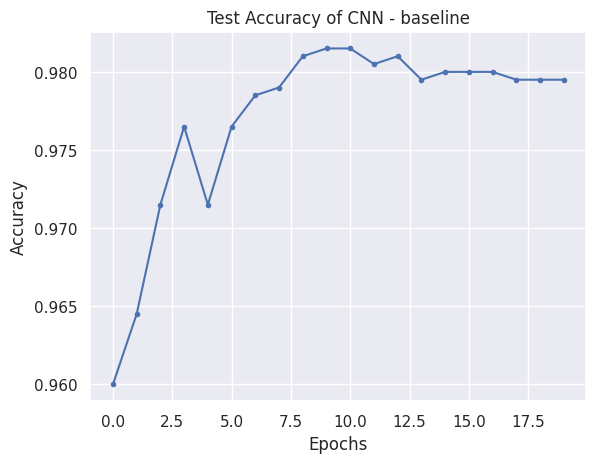

In [ ]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN - baseline')
plt.show()

In [ ]:
# Define model
model = CNNnet()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
              ReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
       BatchNorm2d-8             [-1, 32, 4, 4]              64
              ReLU-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 2, 2]           8,256
      BatchNorm2d-11             [-1, 64, 2, 2]             128
             ReLU-12             [-1, 64, 2, 2]               0
           Linear-13                  [-1, 100]          25,700
           Linear-14                   

In [ ]:
# ==========================
# Variant 1: Shallower Network (2 Conv layers)
# ==========================
class CNNnet_Shallow(nn.Module):
    def __init__(self):
        super(CNNnet_Shallow, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(32 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# ==========================
# Variant 2: Deeper Network with Dropout
# ==========================
class CNNnet_Deep(nn.Module):
    def __init__(self):
        super(CNNnet_Deep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ==========================
# Variant 3: Larger Kernels, Fewer Filters
# ==========================
class CNNnet_LargeKernel(nn.Module):
    def __init__(self):
        super(CNNnet_LargeKernel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2, padding=3),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ==========================
# Variant 4
# ==========================
class CNNnet_Deep_normalized(nn.Module):
    def __init__(self):
        super(CNNnet_Deep_normalized, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
from torchsummary import summary

model = CNNnet_Shallow()  # or any variant
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              ReLU-6           [-1, 32, 14, 14]               0
 AdaptiveAvgPool2d-7             [-1, 32, 4, 4]               0
            Linear-8                  [-1, 100]          51,300
            Linear-9                   [-1, 10]           1,010
Total params: 57,462
Trainable params: 57,462
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.22
Estimated Total Size (MB): 0.66
---------------------------------------------

In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.320730 Batch 0/100 
Training Loss:1.168313 Batch 20/100 
Training Loss:0.574195 Batch 40/100 
Training Loss:0.304904 Batch 60/100 
Training Loss:0.259595 Batch 80/100 
Epoch 0, Test Accuracy 93.950 %
Training Loss:0.205027 Batch 0/100 
Training Loss:0.168183 Batch 20/100 
Training Loss:0.103940 Batch 40/100 
Training Loss:0.168793 Batch 60/100 
Training Loss:0.168564 Batch 80/100 
Epoch 1, Test Accuracy 95.800 %
Training Loss:0.146041 Batch 0/100 
Training Loss:0.098406 Batch 20/100 
Training Loss:0.109367 Batch 40/100 
Training Loss:0.074625 Batch 60/100 
Training Loss:0.119402 Batch 80/100 
Epoch 2, Test Accuracy 96.800 %
Training Loss:0.067386 Batch 0/100 
Training Loss:0.084981 Batch 20/100 
Training Loss:0.033928 Batch 40/100 
Training Loss:0.057416 Batch 60/100 
Training Loss:0.048854 Batch 80/100 
Epoch 3, Test Accuracy 97.100 %
Training Loss:0.064226 Batch 0/100 
Training Loss:0.032628 Batch 20/100 
Training Loss:0.122181 Batch 40/100 
Training Loss:0.101943 Bat

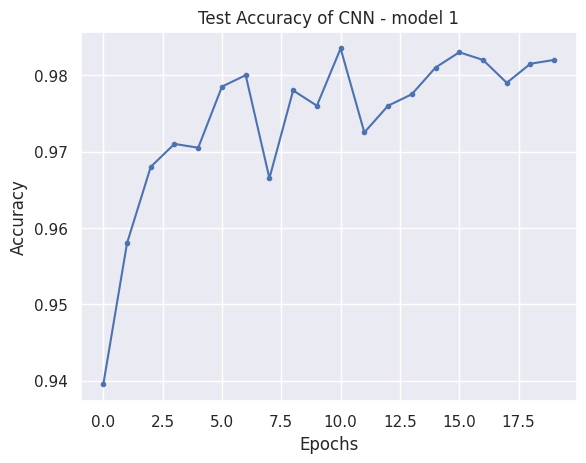

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# where to save the model
model_save = './MNIST_CNN_model1/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN_model1'):
    os.mkdir('MNIST_CNN_model1')

# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN - model 1')
plt.show()

In [ ]:
model = CNNnet_Deep()  # or any variant
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
              ReLU-8          [-1, 128, 14, 14]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
          Dropout-10            [-1, 128, 7, 7]               0
           Linear-11                  [-1, 128]         802,944
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 896,906
Trainable params:

In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.296437 Batch 0/100 
Training Loss:0.725181 Batch 20/100 
Training Loss:0.559459 Batch 40/100 
Training Loss:0.502565 Batch 60/100 
Training Loss:0.191623 Batch 80/100 
Epoch 0, Test Accuracy 96.950 %
Training Loss:0.112549 Batch 0/100 
Training Loss:0.132339 Batch 20/100 
Training Loss:0.140000 Batch 40/100 
Training Loss:0.040563 Batch 60/100 
Training Loss:0.142705 Batch 80/100 
Epoch 1, Test Accuracy 97.450 %
Training Loss:0.174580 Batch 0/100 
Training Loss:0.153636 Batch 20/100 
Training Loss:0.038672 Batch 40/100 
Training Loss:0.120236 Batch 60/100 
Training Loss:0.089636 Batch 80/100 
Epoch 2, Test Accuracy 98.350 %
Training Loss:0.129210 Batch 0/100 
Training Loss:0.069029 Batch 20/100 
Training Loss:0.054159 Batch 40/100 
Training Loss:0.010003 Batch 60/100 
Training Loss:0.068017 Batch 80/100 
Epoch 3, Test Accuracy 98.650 %
Training Loss:0.038343 Batch 0/100 
Training Loss:0.052112 Batch 20/100 
Training Loss:0.060393 Batch 40/100 
Training Loss:0.137138 Bat

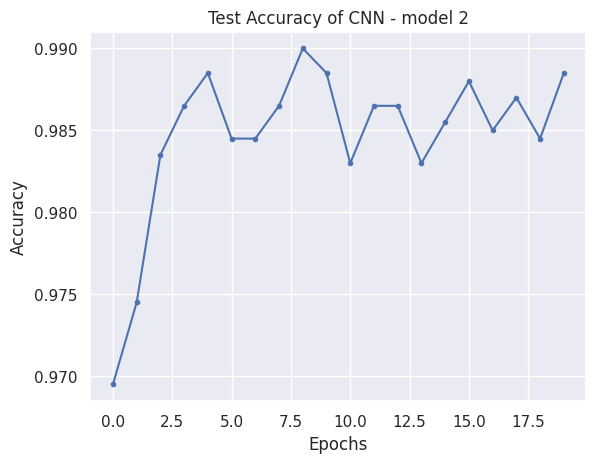

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# where to save the model
model_save = './MNIST_CNN_model2/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN_model2'):
    os.mkdir('MNIST_CNN_model2')

# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN - model 2')
plt.show()

In [ ]:
model = CNNnet_LargeKernel()  # or any variant
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]             400
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           3,216
              ReLU-4             [-1, 16, 7, 7]               0
            Linear-5                   [-1, 10]           7,850
Total params: 11,466
Trainable params: 11,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.04
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.303821 Batch 0/100 
Training Loss:1.971185 Batch 20/100 
Training Loss:0.795501 Batch 40/100 
Training Loss:0.589595 Batch 60/100 
Training Loss:0.370149 Batch 80/100 
Epoch 0, Test Accuracy 87.850 %
Training Loss:0.463060 Batch 0/100 
Training Loss:0.581146 Batch 20/100 
Training Loss:0.314707 Batch 40/100 
Training Loss:0.409333 Batch 60/100 
Training Loss:0.430319 Batch 80/100 
Epoch 1, Test Accuracy 91.350 %
Training Loss:0.309768 Batch 0/100 
Training Loss:0.166413 Batch 20/100 
Training Loss:0.236617 Batch 40/100 
Training Loss:0.504723 Batch 60/100 
Training Loss:0.162202 Batch 80/100 
Epoch 2, Test Accuracy 92.950 %
Training Loss:0.215374 Batch 0/100 
Training Loss:0.241779 Batch 20/100 
Training Loss:0.298928 Batch 40/100 
Training Loss:0.101294 Batch 60/100 
Training Loss:0.245064 Batch 80/100 
Epoch 3, Test Accuracy 94.000 %
Training Loss:0.139944 Batch 0/100 
Training Loss:0.143264 Batch 20/100 
Training Loss:0.120084 Batch 40/100 
Training Loss:0.249532 Bat

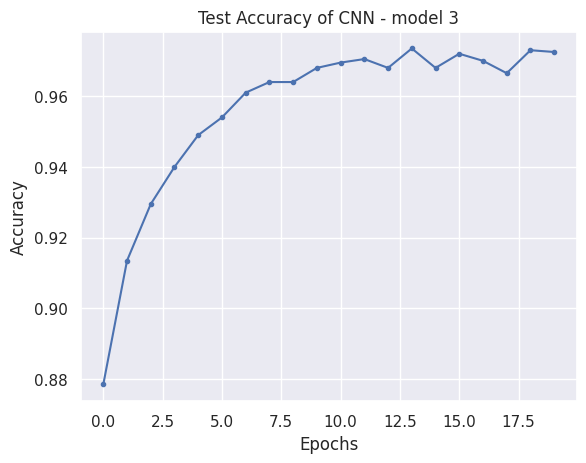

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# where to save the model
model_save = './MNIST_CNN_model3/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN_model3'):
    os.mkdir('MNIST_CNN_model3')

# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN - model 3')
plt.show()

In [ ]:
model = CNNnet_Deep_normalized()  # or any variant
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
      BatchNorm2d-10          [-1, 128, 14, 14]             256
             ReLU-11          [-1, 128, 14, 14]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Dropout-13            [-1, 128, 7, 7]               0
           Linear-14                  [

In [ ]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.463130 Batch 0/100 
Training Loss:0.763341 Batch 20/100 
Training Loss:0.311910 Batch 40/100 
Training Loss:0.319942 Batch 60/100 
Training Loss:0.247585 Batch 80/100 
Epoch 0, Test Accuracy 95.450 %
Training Loss:0.165487 Batch 0/100 
Training Loss:0.308105 Batch 20/100 
Training Loss:0.153263 Batch 40/100 
Training Loss:0.287433 Batch 60/100 
Training Loss:0.292070 Batch 80/100 
Epoch 1, Test Accuracy 96.950 %
Training Loss:0.117916 Batch 0/100 
Training Loss:0.166833 Batch 20/100 
Training Loss:0.078521 Batch 40/100 
Training Loss:0.178607 Batch 60/100 
Training Loss:0.158181 Batch 80/100 
Epoch 2, Test Accuracy 97.650 %
Training Loss:0.204346 Batch 0/100 
Training Loss:0.133331 Batch 20/100 
Training Loss:0.050676 Batch 40/100 
Training Loss:0.161697 Batch 60/100 
Training Loss:0.028989 Batch 80/100 
Epoch 3, Test Accuracy 97.350 %
Training Loss:0.021762 Batch 0/100 
Training Loss:0.212150 Batch 20/100 
Training Loss:0.081816 Batch 40/100 
Training Loss:0.023706 Bat

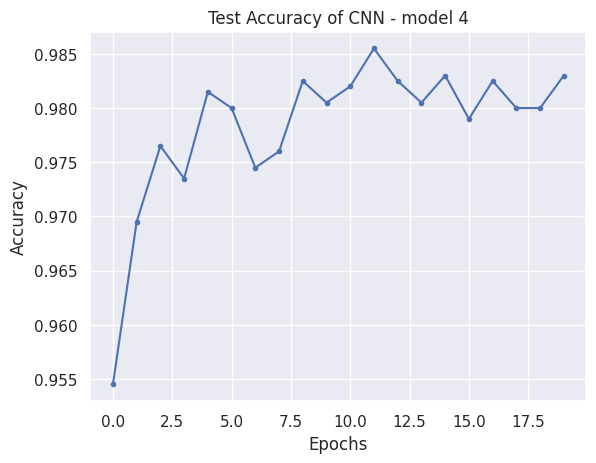

In [ ]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# where to save the model
model_save = './MNIST_CNN_model4/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN_model4'):
    os.mkdir('MNIST_CNN_model4')

# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN - model 4')
plt.show()